In [1]:
import collections
import itertools

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import auc

from utils import unpickle


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [67]:
def params_maker(param_names, param_values):
    product = itertools.product(*param_values)
    params = [list(zip(param_names, p)) for p in product]

    return params

def logdir_maker(attack_params):
    return 'tf_logs/exp3/adv/GM/{}/'.format('_'.join([str(v) for k, v in attack_params]))

def get_result(logdir, experiment):
    '''
    experiment: "accuracy" / "roar" / "kar"
    '''

    return unpickle(logdir.replace('tf_logs', 'results/{}'.format(experiment))[:-1] + '.pickle')

def get_scores(logdirs, experiment):
    scores = collections.OrderedDict([('Saliency', []), ('Grad * Input', [])])

    for logdir in logdirs:

        if 'roar' in experiment:

            baseline = get_result('tf_logs/exp3/standard/', 'roar')['Random']
            baseline = np.concatenate(([0.7366], baseline, [0.1]))

            result = get_result(logdir, experiment)

            for k, v in result.items():

                if k == 'Random':
                    continue

                v = np.concatenate(([0.7366], v, [0.1]))

                delta = baseline - v
                score = auc([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], delta)
                scores[k].append(score)

        elif 'kar' in experiment:

            result = get_result(logdir, experiment)

            baseline = get_result('tf_logs/exp3/standard/', 'kar')['Random']
            baseline = np.concatenate(([0.1], baseline, [0.7366]))[::-1]

            for k, v in result.items():

                if k == 'Random':
                    continue

                v = np.concatenate(([0.1], v, [0.7366]))[::-1]

                delta = v - baseline
                score = auc([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], delta)
                scores[k].append(score)
        else:

            raise Exception('Experiment does not exist.')

    return scores

def accuracies(logdirs, acc_type):
    '''
    acc_type : "train" / "test" / "adv"
    '''

    return [get_result(logdir, 'accuracy')[acc_type.capitalize()] for logdir in logdirs]

def scatter_and_corr(xs, ys, xlim, label=None, c=None, marker=None):
    sc = plt.scatter(xs, ys, label=label, c=c, marker=marker)

    lcorr = np.corrcoef(xs, ys)[0, 1]
    rcorr = spearmanr(xs, ys)[0]

    fit_fn = np.poly1d(np.polyfit(xs, ys, 1))

    plt.plot(np.linspace(xlim[0], xlim[1], num=150), fit_fn(np.linspace(xlim[0], xlim[1], num=150)), c=c, ls='--')

    return sc, lcorr, rcorr


## ROAR KAR

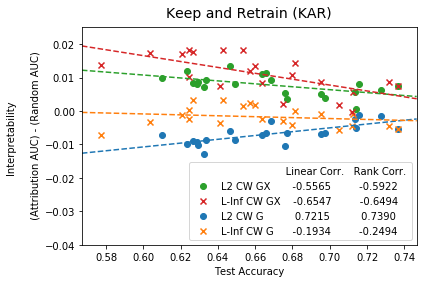

In [94]:
loss_type = 'cw'
axis1 = 'test'
axis2 = 'kar'

epss1 = [round(0.08 * i, 2) for i in range(1, 21)]

attack_paramss1 = params_maker(['eps', 'step_size', 'n_steps', 'norm', 'loss_type'],
                               [epss1, [2], [40], ['2'], [loss_type]])

logdirs1 = ['tf_logs/exp3/standard/'] + [logdir_maker(attack_params) for attack_params in attack_paramss1]

epss2 = [round(0.002 * i, 3) for i in range(1, 21)]

attack_paramss2 = params_maker(['eps', 'step_size', 'n_steps', 'norm', 'loss_type'],
                               [epss2, [0.02], [40], ['inf'], [loss_type]])

logdirs2 = ['tf_logs/exp3/standard/'] + [logdir_maker(attack_params) for attack_params in attack_paramss2]

if axis1 == 'eps':
    xs1 = np.array([0.0] + epss1) / epss1[-1]
    xs2 = np.array([0.0] + epss2) / epss2[-1]
else:
    xs1 = accuracies(logdirs1, axis1)
    xs2 = accuracies(logdirs2, axis1)

res1 = get_scores(logdirs1, axis2)
res2 = get_scores(logdirs2, axis2)

ys11, ys12 = res1['Saliency'], res1['Grad * Input']
ys21, ys22 = res2['Saliency'], res2['Grad * Input']

plt.figure(figsize=(6, 4))

if axis1 == 'eps':
    xlim = [np.minimum(np.min(xs1), np.min(xs2)) - 0.05, np.maximum(np.max(xs1), np.max(xs2)) + 0.05]
else:
    xlim = [np.minimum(np.min(xs1), np.min(xs2)) - 0.01, np.maximum(np.max(xs1), np.max(xs2)) + 0.01]

ylim = [0.005, 0.085] if 'roar' in axis2 else [-0.04, 0.025]

sc11, lcorr11, rcorr11 = scatter_and_corr(xs1, ys11, xlim, label='L2 XEnt G')
sc21, lcorr21, rcorr21 = scatter_and_corr(xs2, ys21, xlim, label='L-Inf XEnt G', marker='x')

sc12, lcorr12, rcorr12 = scatter_and_corr(xs1, ys12, xlim, label='L2 XEnt GX')
sc22, lcorr22, rcorr22 = scatter_and_corr(xs2, ys22, xlim, label='L-Inf XEnt GX', marker='x')

title = 'Remove and Retrain (ROAR)' if 'roar' in axis2 else 'Keep and Retrain (KAR)'
xlabel = 'Attack Strength' if axis1 == 'eps' else '{} Accuracy'.format(axis1.capitalize())
ylabel = 'Interpretability \n\n (Attribution {0}) - (Random {0})'.format('AOC' if 'roar' in axis2 else 'AUC')
loc = ('lower right' if 'roar' in axis2 else 'lower left') if axis1 in ['eps', 'adv'] else (
'lower left' if 'roar' in axis2 else 'lower right')

plt.xlabel(xlabel, fontsize=10)
plt.ylabel(ylabel, fontsize=10)
plt.title(title, fontsize=14, pad=10)
plt.xlim(xlim)
plt.ylim(ylim)

title = ' ' * 29 + 'Linear Corr.' + ' ' * 3 + 'Rank Corr.'

if loss_type == 'xent':
    label11 = 'L2 XEnt G' + ' ' * 7 + '{:7.4f}'.format(lcorr11) + ' ' * 9 + '{:7.4f}'.format(rcorr11) + ' ' * 3
    label21 = 'L-Inf XEnt G' + ' ' * 4 + '{:7.4f}'.format(lcorr21) + ' ' * 9 + '{:7.4f}'.format(rcorr21) + ' ' * 3

    label12 = 'L2 XEnt GX' + ' ' * 5 + '{:7.4f}'.format(lcorr12) + ' ' * 9 + '{:7.4f}'.format(rcorr12) + ' ' * 3
    label22 = 'L-Inf XEnt GX' + ' ' * 2 + '{:7.4f}'.format(lcorr22) + ' ' * 9 + '{:7.4f}'.format(rcorr22) + ' ' * 3
else:
    label11 = 'L2 CW G' + ' ' * 9 + '{:7.4f}'.format(lcorr11) + ' ' * 9 + '{:7.4f}'.format(rcorr11) + ' ' * 3
    label21 = 'L-Inf CW G' + ' ' * 6 + '{:7.4f}'.format(lcorr21) + ' ' * 9 + '{:7.4f}'.format(rcorr21) + ' ' * 3

    label12 = 'L2 CW GX' + ' ' * 7 + '{:7.4f}'.format(lcorr12) + ' ' * 9 + '{:7.4f}'.format(rcorr12) + ' ' * 3
    label22 = 'L-Inf CW GX' + ' ' * 4 + '{:7.4f}'.format(lcorr22) + ' ' * 9 + '{:7.4f}'.format(rcorr22) + ' ' * 3

legend = plt.legend([sc12, sc22, sc11, sc21], [label12, label22, label11, label21], title=title, loc=loc)

plt.savefig('figs/kar_cw_tradeoff.jpg', bbox_inches='tight', dpi=300)

plt.show()
plt.close()
